In [1]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Add # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с файловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
#import seaborn as sns
#sns.set_style('darkgrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height =  320 # Высота уменьшенной картинки 
directory = '/content/drive/My Drive/My Drive/Базы/Поражения/' # Указываем путь к обучающей выборке с оригинальными изображениями
num_classes = 2 # Количество классов на изображении

In [4]:
benign = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

s=0
cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'benign')): # Проходим по всем файлам в каталоге по указанному пути     
    s+=1
    #print(s)
    benign.append(image.load_img(os.path.join(directory + 'benign',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 18.476608991622925c


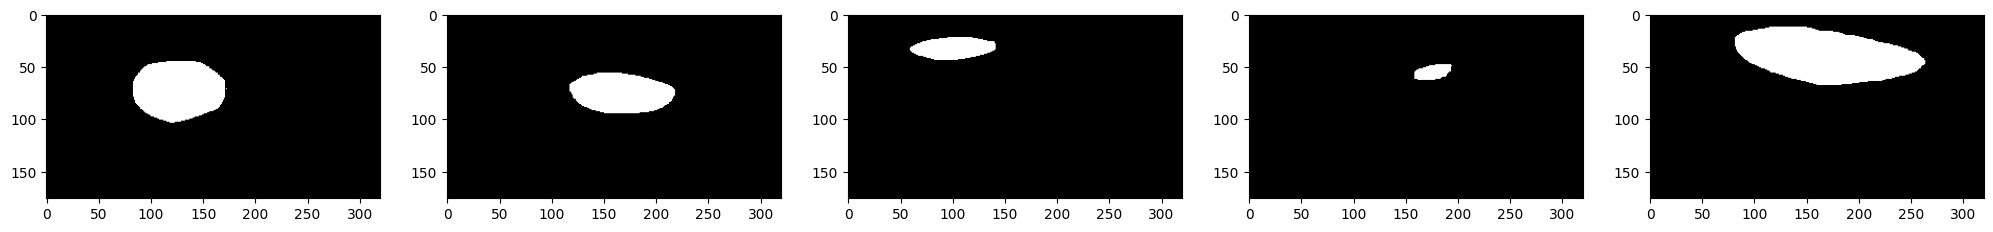

In [5]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(benign) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [6]:
images_origin = benign[::2]
images_segment = benign[1::2]

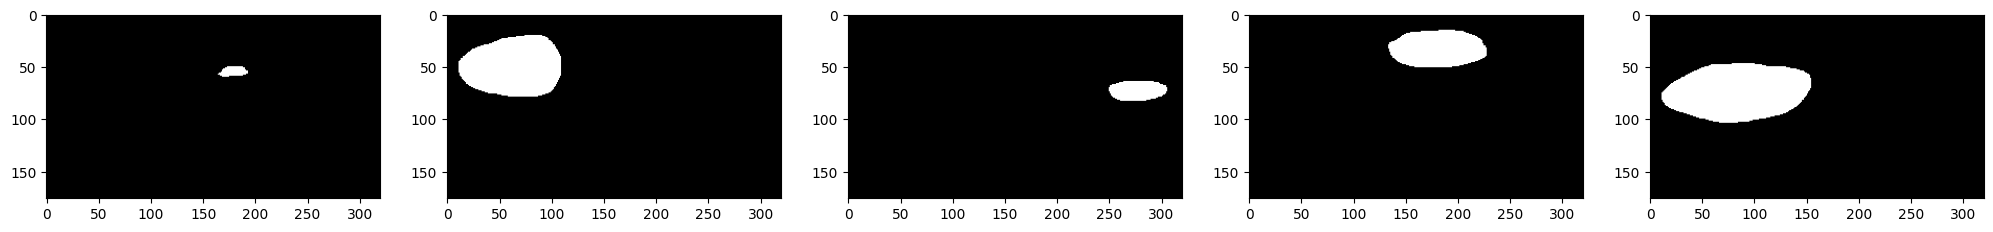

In [7]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = images_segment[i] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [8]:
len(images_segment)

421

In [9]:
len(images_origin)

421

In [10]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index 

In [11]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходному размеру
  return yt # Возвращаем сформированный массив

In [12]:
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегментации
  for seg in data: # Пробегаем по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [13]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_origin: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(421, 176, 320, 3)


In [14]:
cur_time = time.time()
yTrain = yt_prep(images_segment, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
Время обработки:  417.93 c


In [15]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [16]:
y_train.shape

(378, 176, 320, 2)

In [17]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

In [18]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def linknet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Add()([x, block_3_out])                                    # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Add()([x, block_2_out])                                     # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Add()([x, block_1_out]) # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [19]:
model = linknet(2, (img_width, img_height,3))

In [20]:
history = model.fit(xTrain, yTrain, epochs=35, batch_size=16, validation_data = (x_val, y_val)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/35
27/27 [==============================] - 60s 949ms/step - loss: 0.2213 - dice_coef: 0.8896 - val_loss: 115.2221 - val_dice_coef: 0.1144
Epoch 2/35
27/27 [==============================] - 17s 613ms/step - loss: 0.1760 - dice_coef: 0.9107 - val_loss: 19.1285 - val_dice_coef: 0.1223
Epoch 3/35
27/27 [==============================] - 17s 622ms/step - loss: 0.1639 - dice_coef: 0.9159 - val_loss: 45.9918 - val_dice_coef: 0.1291
Epoch 4/35
27/27 [==============================] - 17s 634ms/step - loss: 0.1486 - dice_coef: 0.9216 - val_loss: 9.1920 - val_dice_coef: 0.2305
Epoch 5/35
27/27 [==============================] - 18s 655ms/step - loss: 0.1482 - dice_coef: 0.9223 - val_loss: 30.8551 - val_dice_coef: 0.1155
Epoch 6/35
27/27 [==============================] - 18s 662ms/step - loss: 0.1424 - dice_coef: 0.9275 - val_loss: 6.5327 - val_dice_coef: 0.2649
Epoch 7/35
27/27 [==============================] - 18s 652ms/step - loss: 0.1494 - dice_coef: 0.9243 - val_loss: 12.6781 - v

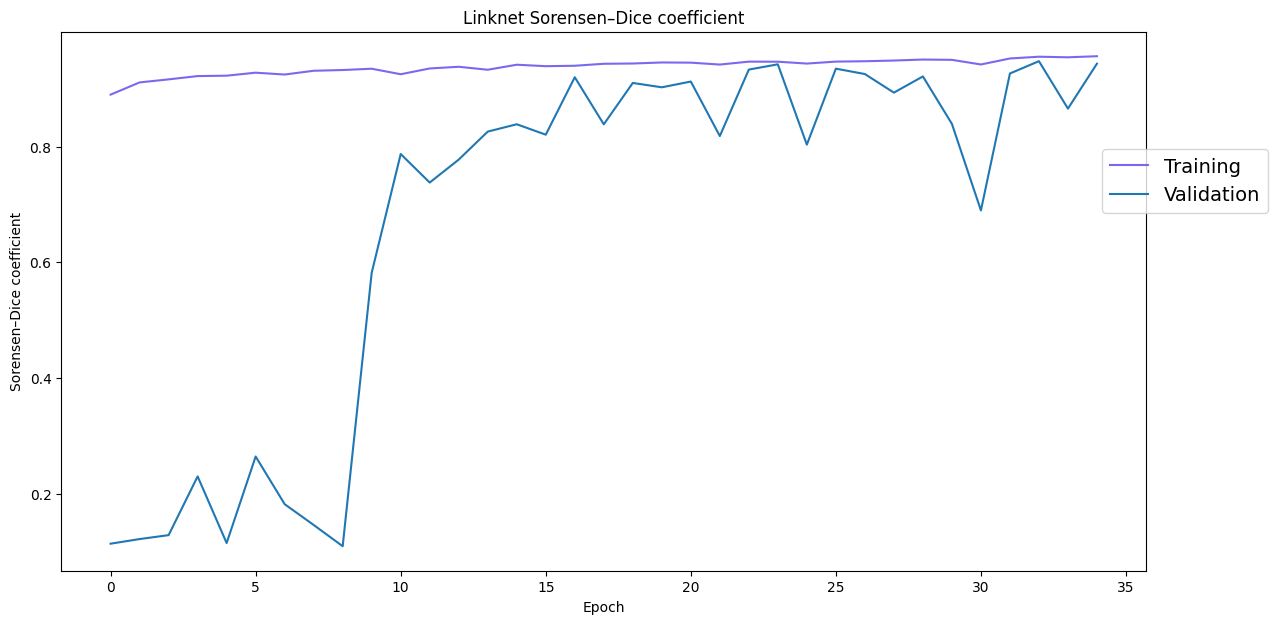

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['dice_coef'], label = 'Training',color = 'mediumslateblue')
plt.plot(history.history['val_dice_coef'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Sorensen–Dice coefficient')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
plt.title('Linknet Sorensen–Dice coefficient')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()


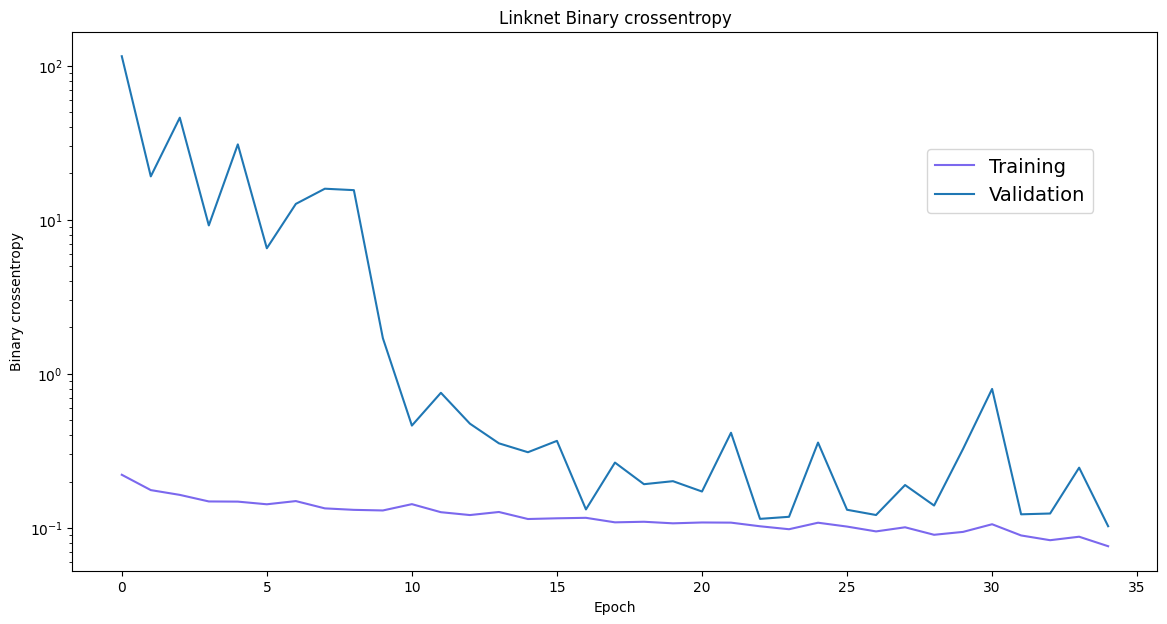

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label = 'Training', color = 'mediumslateblue')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.title('Linknet Binary crossentropy')
plt.show()


In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 0, 0]  # самолет
    return color 